# Demo for data structure *data_neuro*

2017-0928, Shaobo Guan

This short notebooks demonstrates the core data strucure used in this module: **data_neuro**, which conviniently stores the multi-channel neurophysiological data (both, spikes and LFPs) alignted to trial onset (e.g. stimulus onset )

## Section 1: Read neural data usign python-neo package

### 1.1 load neural andbehaviral data

In [173]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd         # pandas tabular DataFrame for task/behavioral data
import matplotlib as mpl    # plot
import matplotlib.pyplot as plt
import re                   # regular expression
import time                 # time code execution
import cPickle as pickle


import dg2df                # for DLSH dynamic group (behavioral data)
import neo                  # data structure for neural data
import quantities as pq
import signal_align         # in this package: align neural data according to task
import PyNeuroAna as pna    # in this package: analysis
import PyNeuroPlot as pnp   # in this package: plot
import misc_tools           # in this package: misc

import data_load_DLSH       # package specific for DLSH lab data

%matplotlib inline

In [61]:
""" load data """
keyword_tank = '.*GM32.*U16.*161015.*'
block_type = 'srv'

""" load neural data and behaviral data that matches the keywords """
[blk, data_df, name_tdt_blocks] = data_load_DLSH.load_data('d_.*{}.*'.format(block_type), keyword_tank,
                                                           tf_interactive=False,
                                                           dir_tdt_tank='/shared/homes/sguan/neuro_data/tdt_tank',
                                                           dir_dg='/shared/homes/sguan/neuro_data/stim_dg')

filename_common = misc_tools.str_common(name_tdt_blocks)
dir_temp_fig = './temp_figs'

""" make sure data field exists and standardize it """
data_df = data_load_DLSH.standardize_data_df(data_df, filename_common)
blk = data_load_DLSH.standardize_blk(blk)

the following tdt blockes are selected: ['d_srv_mask_101516003', 'd_srv_mask_101516004']
the following dg files are selected: ['d_srv_062216008', 'd_srv_062216009', 'd_srv_062316002', 'd_srv_062316003', 'd_srv_062316004', 'd_srv_072216002', 'd_srv_072216003', 'd_srv_072216004', 'd_srv_mask_010217002', 'd_srv_mask_010317002', 'd_srv_mask_010517002', 'd_srv_mask_010617003', 'd_srv_mask_011017002', 'd_srv_mask_011217002', 'd_srv_mask_011317003', 'd_srv_mask_011617002', 'd_srv_mask_011717003', 'd_srv_mask_020717006', 'd_srv_mask_021417002', 'd_srv_mask_022017003', 'd_srv_mask_022117002', 'd_srv_mask_022317006', 'd_srv_mask_022817001', 'd_srv_mask_030217002', 'd_srv_mask_030717005', 'd_srv_mask_031517003', 'd_srv_mask_032317004', 'd_srv_mask_081016002', 'd_srv_mask_081016003', 'd_srv_mask_081016004', 'd_srv_mask_081016005', 'd_srv_mask_081716002', 'd_srv_mask_081716003', 'd_srv_mask_090216002', 'd_srv_mask_090216003', 'd_srv_mask_090816002', 'd_srv_mask_090816003', 'd_srv_mask_100716004', '


finish loading tdt blocks


loading dg: d_srv_mask_101516003.dg
loading dg: d_srv_mask_101516004.dg
finish loading and concatenating dgs

Now the neural data and behaviroal data hava been loaded.

The neural data is stored in blk, and the behaviral data is stroed in data_df

## 1.2 the stuture of the raw neural data: blk:

blk is the block object defined in the python-neo module:

htts://neuralensemble.org/neo/

>  Neo is a package for representing electrophysiology data in Python, together with support for reading a wide range of neurophysiology file formats including
Spike2, NeuroExplorer, AlphaOmega, Axon, Blackrock, Plexon, Tdt.

We here use the neo package to read the neural data recorded from differnt equipments into a standard format, therefore the later analysis is independet of the ogirinal data format, making our analysis pakage platform-indepdent

The neo block object **blk** contains multiple segments, each corresponding to a recorded data file, e.g. a experiment session.  Every segments contains several forms of data, e.g. spiketrains (time stamps), anglogsignals (e.g. continuouly sampled LFP signal) and events (e.g., timing information of the start and end of a trial), as is shown below



In [62]:
blk.segments[0].spiketrains[0]

SpikeTrain
name: 'Chan1 Code1'
annotations: {'channel_index': 1, 'sort_code': 1}

In [63]:
blk.segments[0].analogsignals[0]

AnalogSignal with 1 channels of length 2062080; units V; datatype float32 
name: 'LFPs 1'
annotations: {'channel_index': 1}
sampling rate: 1017.25262451 Hz
time: 9.53674316406e-07 s to 2027.10708361 s

In [64]:
blk.segments[0].events

[Event name: 'Tick' annotations: {'channel_index': 0},
 Event name: 'obsv' annotations: {'channel_index': 0},
 Event name: 'obs\\' annotations: {'channel_index': 25199}]

## Section 2 structure of the behavioral data:

Other than the neural data, we ususally keep tracks of the task (e.g. the identity and onset time of a visual stimulus) and animals behaviral response (the correctness and timing of lever press and eye movement)

The behviral data may be lab-specific, but typically organized as a table-like structure where every row represetn one trial and over column represent one feature of the task (stimulus onse, object identity, correct/wrong response, etc.)

In [92]:
print('Here are all the column names of the example table data_df:')
print(data_df.columns.tolist())

print("Here are several example columns of the first 10 rows of the table")
data_df[['obsid', 'stimon', 'stim_names', 'stim_familiarized', 'mask_opacity']].head(10)

Here are all the column names of the example table data_df:
['datecode', 'day', 'edge_blur', 'ems', 'endobs', 'endtrial', 'eyedist', 'file', 'fileid', 'fixjump', 'fixjump_pos', 'fixoff', 'fixon', 'grayscale', 'ids', 'mask_extensions', 'mask_index', 'mask_linearity', 'mask_names', 'mask_opacity', 'mask_orientation', 'mask_paths', 'mask_scale', 'month', 'nsaccades', 'obsid', 'order', 'reward_times', 'sacamps', 'sacdirs', 'sacfroms', 'sacstops', 'sactimes', 'sactos', 'sacvels', 'stim_categories', 'stim_durations', 'stim_extensions', 'stim_familiarized', 'stim_names', 'stim_paths', 'stim_posttimes', 'stim_rotations', 'stim_scales', 'stim_types', 'stimoff', 'stimon', 'stimtype', 'subj', 'targecc', 'year', 'filename', 'fileindex', '', 'obs_total', 'mask_opacity_int', 'stim_sname']
Here are several example columns of the first 10 rows of the table


,obsid,stimon,stim_names,stim_familiarized,mask_opacity
0,2,719,dog_n02084071_18815,0,0.5
1,2,1249,face_n09618957_857,0,0.7
2,2,1780,house_n03545150_3480,1,0.7
3,2,2310,car_n02958343_5461,1,0.5
4,2,2840,face_n09618957_5162,1,0.5
5,3,529,face_n09618957_5162,1,0.0
6,3,1059,car_n02958343_6119,0,0.7
7,3,1590,dog_n02084071_33057,1,0.7
8,3,2120,bird_n01503061_10012,1,0.7
9,3,2651,bird_n01503061_18047,0,0.5


## Section 3: `data_neuro`: neural response aligned to the task

the structure `data_neuro` aligns the raw neural data `blk` to the trial structure defined by the behaviral data `data_df`

We usually align neuronal response to some important timestamps (eg. visual stimulus onset, motor command execusion, etc) and study the neuronal activity in respond to different exprimental conditions.  To do that efficiently, we organized data into the structure: `data_neuro`

### 3.1 create `data_neuro` by aligning neural data to event

In [183]:
""" align neural data to the event 'stimon' from behaviral data """

# get the timestamps of the stimon event relative to the sync signal, and translate it to the absolute time in the neural data file
ts_StimOn = data_load_DLSH.get_ts_align(blk, data_df, dg_tos_align='stimon')
# align the neural data according to the timestamps, here only use the spiketrains data
data_neuro = signal_align.blk_align_to_evt(blk, ts_StimOn, [-0.100, 0.600], type_filter='spiketrains.*',
                                           name_filter='.*Code[1-9]$', spike_bin_rate=1000)

### 3.2 structure of `data_neuro`

In [184]:
print('the dictionary data_neural contains the following fields:    {}'.format(data_neuro.keys()))

print('the "data" field contains a 3D numpy array of shape  {}'.format(data_neuro['data'].shape) )

print('the "ts" field contains a 1D numpy array of length {}'.format(data_neuro['ts'].shape) )

print('the "signal_info" field contains a table of length {}'.format(data_neuro['signal_info'].shape) )

print('the behaviral data table data_df contains {} rows'.format(len(data_df)))

the dictionary data_neural contains the following fields:    ['signal_info', 'data', 'ts']
the "data" field contains a 3D numpy array of shape  (2400, 700, 39)
the "ts" field contains a 1D numpy array of length (700,)
the "signal_info" field contains a table of length (39,)
the behaviral data table data_df contains 2400 rows


`data_neuro['data']` contains the aligned neural data.

The shape of it is [num_trials, num_timesstampts, num_signals], where every entry represent (the number_of_spikes * spike_bin_rate) during a time bin of a trail from a signal

The example data contains:

- 2400 trials, whose the task/behaviroral info is stored at table `data_df`
- 700 timestamps (sampled at 1000 Hz, which is specified when calling funciton `blk_align_to_evt(spike_bin_rate=1000)`), the timing of every timestamp relative to the aligning event onset is strored in `data_neuro['ts']`; here the aligning event is `'stimon'`
- 39 signals, here every signal is either MUA or SUA, whose names are shown below (show the first 5 rows): 

In [208]:
data_neuro['data'][0:10, 200:208, 2]

array([[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,  1000.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,  1000.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,  1000.,     0.]])

In [185]:
data_neuro['signal_info'][0:5]

array([('Chan1 Code1', 'spiketrains',  1000., 1, 1),
       ('Chan1 Code2', 'spiketrains',  1000., 1, 2),
       ('Chan2 Code2', 'spiketrains',  1000., 2, 2),
       ('Chan5 Code1', 'spiketrains',  1000., 5, 1),
       ('Chan6 Code1', 'spiketrains',  1000., 6, 1)], 
      dtype=[('name', 'S32'), ('type', 'S32'), ('sampling_rate', '<f8'), ('channel_index', '<i8'), ('sort_code', '<i8')])

We can easily get a rough overview of the data by plotting it usign funciton `DataNeuroSummaryPlot()`

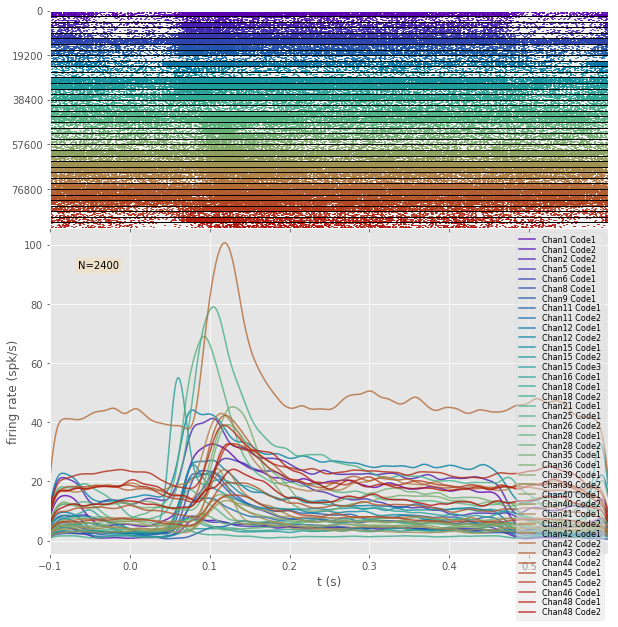

In [191]:
plt.figure(figsize=(10,10))
pnp.DataNeuroSummaryPlot(data_neuro, tf_legend=True)

In this figure, the rasters and PSTH across all trials and all singals are shown relative to the aligning evetn onset (`'stimon'` in this example).  Every trance represents a signal with their names listed in the legend, `averaged across N=2400` trials

### 3.3 Group data by task/behaviroal conditions

We usually want to group the data according to the conditions that we care about, e.g. differnt visual stimulus, correct/wrong response, etc.

In whis example dataset, I only want to get the trials where 'mask_opacity' equals zero, and then group data by `'stim_sname'`

In [158]:
data_neuro = signal_align.neuro_sort(data_df, grpby=['stim_sname'], fltr=data_df['mask_opacity']==0.0, neuro=data_neuro)

In [167]:
print('Now data_neuron contains the following fields:{}\n'.format(data_neuro.keys()))

print('field fltr')
print(data_neuro['fltr'])
print('')
print('field grpby')
print(data_neuro['grpby'])
print('')
print('field cdtn')
print(data_neuro['cdtn'])
print('')
print('field cdtn_indx of one condition: bird_fam_10012')
print(data_neuro['cdtn_indx']['bird_fam_10012'])
print('')

Now data_neuron contains the following fields:['data', 'ts', 'cdtn_indx', 'cdtn', 'signal_info', 'grpby', 'fltr']

field fltr
[False False False ...,  True False False]

field grpby
['stim_sname']

field cdtn
['bird_fam_10012', 'bird_fam_3563', 'bird_nov_10887', 'bird_nov_18047', 'car_fam_5461', 'car_fam_7432', 'car_nov_427', 'car_nov_6119', 'dog_fam_33057', 'dog_fam_5126', 'dog_nov_18815', 'dog_nov_28122', 'face_fam_5162', 'face_fam_640', 'face_nov_7514', 'face_nov_857', 'house_fam_10089', 'house_fam_3480', 'house_nov_2461', 'house_nov_5452']

field cdtn_indx of one condition: bird_fam_10012
[  98  138  154  170  175  196  217  269  495  503  505  582  622  639  684
  758  803 1011 1088 1166 1249 1336 1388 1418 1445 1480 1574 1603 1613 1768
 1790 1936 1962 2037 2056 2125 2239 2244 2337 2363]



We now see that there are several fields added to the dictionary 'data_neuro'

Note that the filter and group-by action **does not** acturally modify the actrual data, but only adds the field `'cdtn_indx'` that stores the index of the trials falliing into that condition.

In this example, we first filter the trail by setting `fltr=data_df['mask_opacity']==0.0`, therefore only trials satisfying this constain can be listed in the `cdtn_indx`; we also group trials by the field `'stim_snames'` of table `data_df`, and therefore trials from each unique condition of `'stim_sname'` will be listed in `'cdtn_indx'`

We now can get the spiking data from trials where `data_df['mask_opacity']==0.0` and `data_df['stim_sname']=='bird_fam_10012'` as follows


In [170]:
index_of_interest = data_neuro['cdtn_indx']['bird_fam_10012']
data_of_interest = data_neuro['data'][index_of_interest, :, :]
data_of_interest.shape

(40, 700, 39)

We can tell there are 40 trials that falls in our selection (still 700 timestamps and 39 channels)

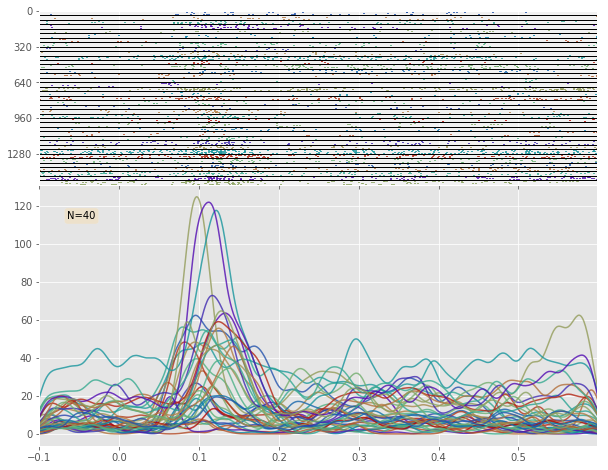

In [180]:
plt.figure(figsize=(10,8))
pnp.PsthPlot(data_of_interest, ts = data_neuro['ts'], sk_std=0.01)

 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9709cc2190>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f970922c110>]], dtype=object)]

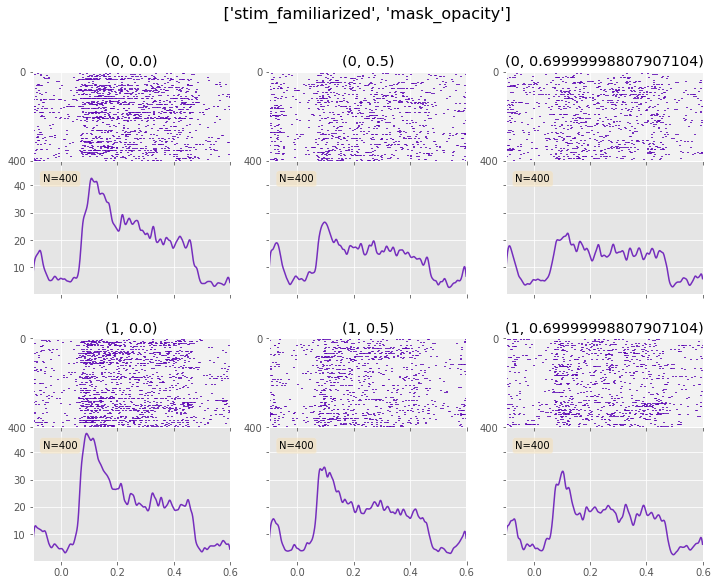

In [246]:
reload(pnp)
data_df['stim_familiarized']
pnp.PsthPlotCdtn(data_neuro, data_df, grpby=['stim_familiarized', 'mask_opacity'], sk_std=0.005, i_signal=0)

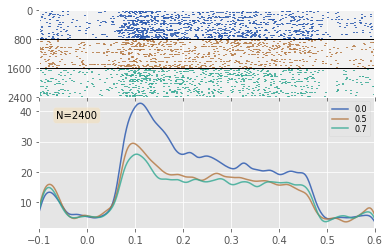

In [257]:
pnp.PsthPlot(data_neuro['data'][:,:,0], ts=data_neuro['ts'], cdtn=data_df['mask_opacity'], sk_std=0.01, tf_legend=True)

In [250]:
reload(pnp)

<module 'PyNeuroPlot' from 'PyNeuroPlot.py'>